In [5]:
import matplotlib.pyplot as plt

# for reloading of modules
import importlib
from helpers import bohmian_integrator
from helpers import logging, physics2dsim_split_spin, plotting_spin, video_spin, data
from helpers import bohmian_plotter

def reload_modules():
    importlib.reload(logging)
	
    importlib.reload(physics2dsim_split_spin)
    importlib.reload(plotting_spin)
    importlib.reload(video_spin)
    importlib.reload(data)
    importlib.reload(bohmian_integrator)
    importlib.reload(bohmian_plotter)

# Call this whenever you need to reload the modules
reload_modules()

# Then your regular imports
from helpers.logging import *
from helpers.physics2dsim_split_spin import simulate_2d_spin
from helpers.plotting_spin import plot_simulation_heatmaps_spin
from helpers.video_spin import create_animation_spin
from helpers.data import *
from helpers.bohmian_integrator import *
from helpers.bohmian_plotter import *

In [3]:
# with weak magnetic barrier
simulation_data_2, params_2, timestamp_2 =  load_simulation_data('./simulations_data/spin/simulation_20250425_01-33step_0.01_quantum_evolution_circular_mag_barrier_strength_32.0.pkl')


In [108]:
import numpy as np
alpha = beta = 1/np.sqrt(2)
vx_all, vy_all = get_velocity_field(simulation_data_2, params_2, alpha=alpha, beta=beta)

In [109]:
# pick a frame for analysis
k = 350
# First convert the data to numpy arrays
psi_up = np.asarray(simulation_data_2['psi_up_list'][k])
psi_down = np.asarray(simulation_data_2['psi_down_list'][k])

# Then multiply by alpha and beta
rho = np.abs(psi_up)**2 + np.abs(psi_down)**2

In [110]:
# rebuild grid coordinates from the saved 1-D axes
y = np.asarray(simulation_data_2['y'])          # shape (Ny,)
x = np.asarray(simulation_data_2['x'])          # shape (Nx,)
t = np.asarray(simulation_data_2['t'])          # shape (Nx,)
X, Y = np.meshgrid(x, y, indexing='xy')       # X and Y shapes (Ny, Nx)

In [111]:
dx, dy = x[1] - x[0], y[1] - y[0]
dx, dy

(0.078125, 0.078125)

In [112]:
rho.sum()*dx*dy

0.9999996515010687

In [113]:
print ( 'vy should be', -1*9.81*t[k])

vy should be -17.1675


In [114]:
# bulk centre of the packet - Y position
y_com = (rho * Y).sum() / rho.sum()
print("〈y〉  =", y_com)

# Bohmian speed at the density maximum
i,j    = np.unravel_index(np.argmax(rho), rho.shape)
v_peak = np.sqrt(vx_all[k,i,j]**2 + vy_all[k,i,j]**2)
print("‖v‖peak =", v_peak)

〈y〉  = -0.021570820672699054
‖v‖peak = 17.160617628927756


In [85]:
import math

In [98]:
lambda_min = 2*math.pi * 1 / 17.5
print (f"dx should <= {lambda_min / 8}")

dx should <= 0.04487989505128276


In [100]:
lambda_min

0.35903916041026207

$$
\lambda_{\text{min}} = \frac{2\pi * \hbar|_{\hbar=1}}{17.5} \approx 0.359
$$

$$
\Delta X_{\text{min}} \leq \frac{\lambda_{\text{min}}}{8} \approx 0.0448
$$

In [87]:
dx, dy

(0.078125, 0.078125)

Okay so..... my grid dx and dy is almost TWICE of what it should be....

In [88]:
40/512

0.078125

In [89]:
40/1024

0.0390625

In [76]:
40/2048

0.01953125

In [105]:
4 * 1024 * 1024 * 300 / 1000000

1258.2912

OKAY FINALLTY

In [6]:
trajectories_2 = compute_bohmian_trajectories(simulation_data_2, params_2,
                                           alpha=1/np.sqrt(2),
                                           beta =1/np.sqrt(2),
                                           n_trajectories=200, random_seed=777)

CFL parameter: 21051.363631746768
C after fix = 0.2499983805399469


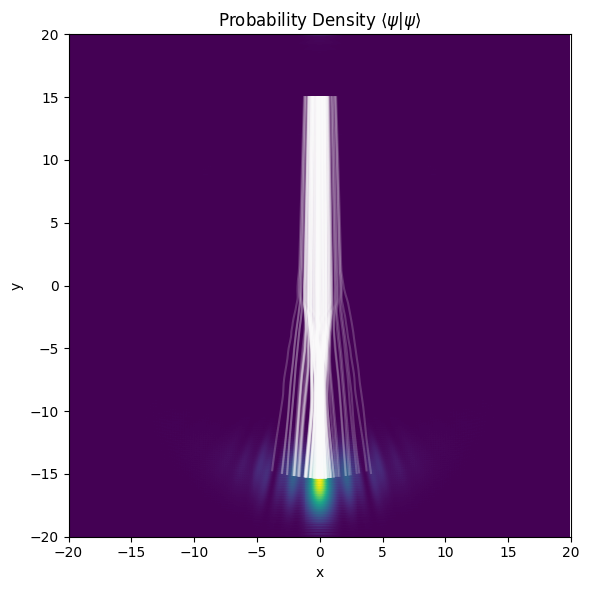

In [9]:
plot_trajectories(trajectories_2, params_2, simulation_data=simulation_data_2,
					alpha=1/np.sqrt(2),
					beta =1/np.sqrt(2),
					same_chart=True,
					till_frame=250
				)

Average time inside barrier: 0.595 (same units as t)


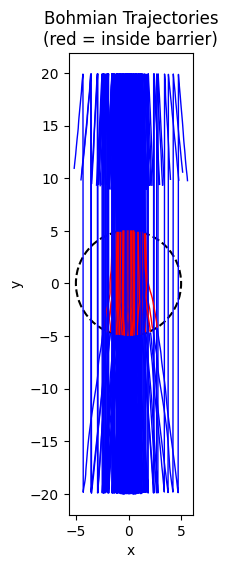

In [11]:
# Example usage (assuming `traj` and `t` are defined from your code):
t = simulation_data_2['t']

# Define barrier radius (e.g. 0.5 times your magnetic barrier size)
R = (2.5)/2*params_2['mag_barrier_width']  # replace barrier_radius_value with your actual radius
inside_mask, times_inside, avg_time_inside = analyze_barrier_passage(trajectories_2, t, R)

print(f"Average time inside barrier: {avg_time_inside:.3f} (same units as t)")

# Plot trajectories with inside segments in red
plot_trajectories_with_barrier(trajectories_2, inside_mask, R)

# Plot density of points inside
# Optionally, specify extent=((x_min, x_max), (y_min, y_max))
# plot_density_inside(trajectories_2, inside_mask, bins=150)


<Axes: ylabel='Count'>

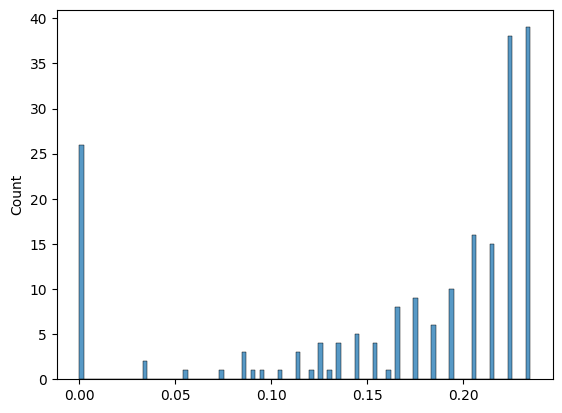

In [180]:
import seaborn as sns
sns.histplot(times_inside, bins=100)

In [12]:
times_inside[times_inside>0.01].mean()

0.5946499999999999

In [186]:
print (f"Average time inside barrier: {avg_time_inside:.3f} (same units as t)")

Average time inside barrier: 0.170 (same units as t)


## Let's compare with larmor clock

In [187]:
import numpy as np
import matplotlib.pyplot as plt

def measure_precession_angle(sim_data, dx, dy, hbar=1.0):
    """
    Given sim_data which contains lists of complex wavefunction arrays
    psi_up_list[t], psi_down_list[t], compute:
       - <sigma_x>(t)
       - <sigma_y>(t)
       - theta_x(t) = atan2(<sigma_y>, <sigma_x>)
    for each time step.
    Return arrays time_list, sx_list, sy_list, theta_list
    that you can plot or animate.
    """

    psi_up_list   = sim_data["psi_up_list"]   # shape [t][Nx,Ny] (complex)
    psi_down_list = sim_data["psi_down_list"] # shape [t][Nx,Ny] (complex)
    time_list     = sim_data["t"]             # shape [n_steps]

    n_steps = len(time_list)
    sx_list = np.zeros(n_steps, dtype=np.float64)
    sy_list = np.zeros(n_steps, dtype=np.float64)
    theta_list = np.zeros(n_steps, dtype=np.float64)

    # We assume wavefunction is normalized so that sum(|psi|^2)*dx*dy = 1
    # Then <sigma_x> in [-1,+1], <sigma_y> in [-1,+1].

    for i in range(n_steps):
        psi_up   = psi_up_list[i]
        psi_down = psi_down_list[i]

        # Overlap for cross terms:
        #   overlap = ∫ psi_up^*(r) psi_down(r) dr
        overlap_x = np.sum(np.conjugate(psi_up) * psi_down + np.conjugate(psi_down) * psi_up)
        overlap_y = np.sum(np.conjugate(psi_up) * psi_down - np.conjugate(psi_down) * psi_up)
        # multiply by dx*dy for the integral
        overlap_x *= (dx*dy)
        overlap_y *= (dx*dy)

        # <sigma_x> = overlap_up_dn + conj => 2 Re(overlap)
        sig_x = overlap_x.real
        # <sigma_y> = 2 Im(overlap)
        sig_y = overlap_y.imag

        sx_list[i] = sig_x
        sy_list[i] = sig_y
        theta_list[i] = np.arctan2(sig_y, sig_x)  # angle in [-pi, pi]

    return time_list, sx_list, sy_list, theta_list


def plot_precession(time_list, sx_list, sy_list, theta_list):
    """Make some simple plots of the net spin over time."""
    fig, axs = plt.subplots(3, 1, figsize=(6,8), sharex=True)

    axs[0].plot(time_list, sx_list, label=r'$\langle \sigma_x \rangle$')
    axs[0].legend(loc='best'); axs[0].grid(True)

    axs[1].plot(time_list, sy_list, label=r'$\langle \sigma_y \rangle$')
    axs[1].legend(loc='best'); axs[1].grid(True)

    axs[2].plot(time_list, theta_list, label=r'Precession angle $\theta$')
    axs[2].legend(loc='best'); axs[2].grid(True)
    axs[2].set_xlabel("Time")

    fig.tight_layout()
    plt.show()

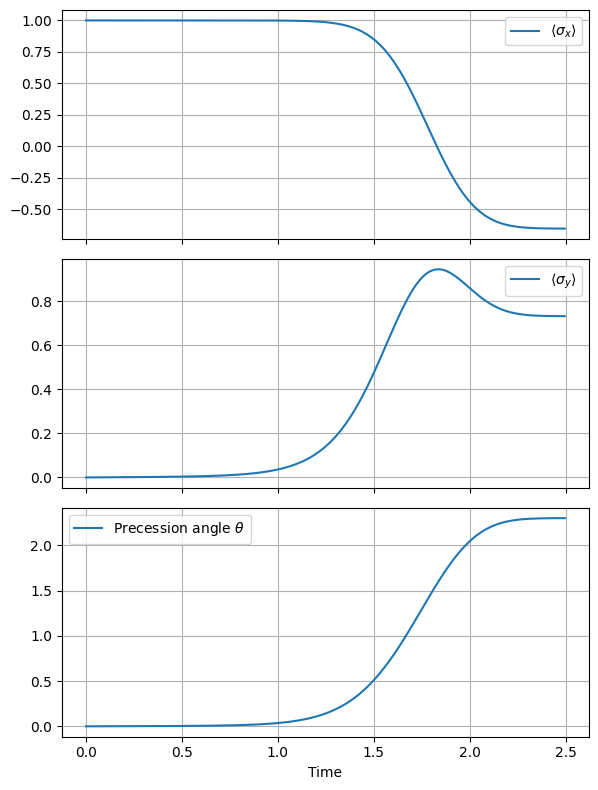

In [188]:
# Suppose we've stored wavefunction arrays in simulation_data["psi_up_list"], etc.
dx = (simulation_data_2["x"][1] - simulation_data_2["x"][0])
dy = (simulation_data_2["y"][1] - simulation_data_2["y"][0])

t_array, sx_array, sy_array, theta_array = measure_precession_angle(
	simulation_data_2, dx=dx, dy=dy, hbar=1.0
)

plot_precession(t_array, sx_array, sy_array, theta_array)

In [189]:
def calc_larmor_frequency(params, hbar=1.0):
	"""
	Compute the approximate Larmor frequency (omega_L) from simulation parameters.
	
	The code uses 'mag_barrier_strength' as the potential amplitude for spin-up,
	and the opposite sign for spin-down, producing an energy splitting of
	2 * mag_barrier_strength at the barrier peak. Then:
		omega_L = (energy difference) / hbar = 2 * mag_barrier_strength / hbar
	
	Parameters
	----------
	params : dict
		A dictionary with simulation parameters, expected to include:
			'mag_barrier_strength': float
				Peak amplitude of the spin-dependent barrier potential.
	hbar : float
		Reduced Planck's constant in our chosen units (default 1.0).
	
	Returns
	-------
	float
		The Larmor frequency in the same time units used by the simulation.
	"""
	v0 = params['mag_barrier_strength']
	delta_E = 2.0 * v0  # spin-up sees +v0, spin-down sees -v0
	omega_L = delta_E / hbar
	return omega_L

In [207]:
w_l = calc_larmor_frequency(params_2)
w_l # radians per time unit in simulation

print (f"Larmor frequency: {w_l} rad/time unit, or {w_l/(2*np.pi)} Hz")

tau = theta_array[-1] / calc_larmor_frequency(params_2)
print (f"tau = {tau }")

Larmor frequency: 4.0 rad/time unit, or 0.6366197723675814 Hz
tau = 0.5751788120828994


In [205]:
avg_time_inside

0.5857249999999999

Use guassian $w_L$

In [216]:
# psi_up_list, psi_down_list, t_arr come from your simulate_2d_spin(...)
sx = []
sy = []

# t_arr = simulation_data_2["t"]

# for psi_u, psi_d in zip(simulation_data_2["psi_up_list"], simulation_data_2["psi_down_list"]):
#     sx.append( 2.0 * np.real(np.vdot(psi_d, psi_u)) )   # ⟨σ_x⟩
#     sy.append( 2.0 * np.imag(np.vdot(psi_d, psi_u)) )   # ⟨σ_y⟩



t_arr, sx, sy, theta = measure_precession_angle(
	simulation_data_2, dx=dx, dy=dy, hbar=1.0
)


Δθ = 2.300715248331598
τ_Larmor = 1.9198211879171008


In [219]:
# sx = np.array(sx);  sy = np.array(sy)
# theta   = np.unwrap(np.arctan2(sy, sx))
omega_L = np.gradient(theta, t_arr)

omega_ref = 2.0 * params_2["mag_barrier_strength"] / params_2["hbar"]
tau_Lar   = np.trapz(omega_L/omega_ref, t_arr)

print("Δθ =", theta[-1]-theta[0])
print("τ_Larmor =", tau_Lar)

Δθ = 2.300715248331598
τ_Larmor = 0.5751788120828993


In [217]:
omega_ref = 2.0 * params_2["mag_barrier_strength"] / params_2["hbar"]

# preferred: use total phase difference
tau_Lar = (theta[-1] - theta[0]) / omega_ref

print("Δθ =", theta[-1] - theta[0])
print("τ_Larmor =", tau_Lar)

Δθ = 2.300715248331598
τ_Larmor = 0.5751788120828994


In [221]:
import numpy as np
from scipy.integrate import quad

def larmor_time_gaussian(params):
    # unpack what we need
    x0, y0      = params['x0'], params['y0']
    p0x, p0y    = params['p0x'], params['p0y']
    m, g        = params['m'],  params.get('g', 0.0)
    xB, yB      = params['mag_barrier_center_x'], params['mag_barrier_center_y']
    sigmaB      = params['mag_barrier_width']
    sigmaW      = params['sigma']
    V0          = params['mag_barrier_strength']
    hbar        = params['hbar']
    Tsim        = params['n_steps'] * params['dt']
    
    f = sigmaB**2 / (sigmaB**2 + sigmaW**2)          # static prefactor
    denom = 2*(sigmaB**2 + sigmaW**2)
    
    # classical CoM trajectory
    vx, vy = p0x/m, p0y/m
    
    def integrand(t):
        x_t = x0 + vx*t
        y_t = y0 + vy*t - 0.5*g*t**2
        r2  = (x_t - xB)**2 + (y_t - yB)**2
        return np.exp(-r2/denom)
    
    I, _ = quad(integrand, 0.0, Tsim, epsabs=1e-10)
    
    tau_Lar = f * I                                   # already dimensionless
    omega_max = 2.0*V0/hbar
    Delta_theta = omega_max * tau_Lar                 # sanity check
    
    return tau_Lar, Delta_theta

In [222]:
larmor_time_gaussian(params_2)

(0.5873611228683404, 2.3494444914733617)

: 

<Axes: >

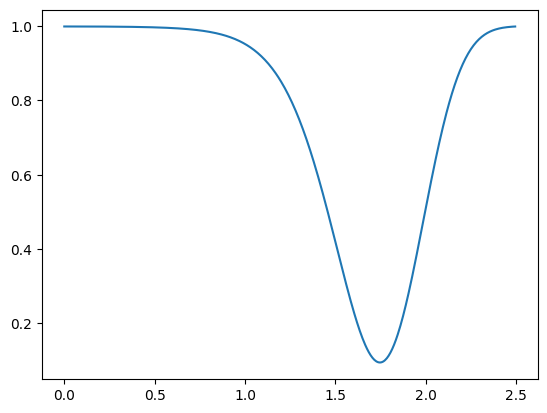

In [215]:

sns.lineplot(x=t_arr, y=1-(omega_L/omega_ref))


<Axes: >

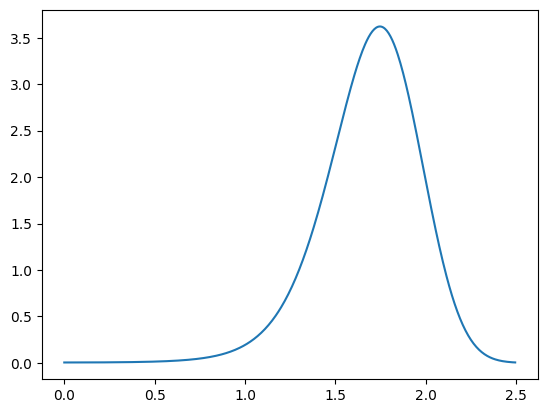

In [213]:

sns.lineplot(x=t_arr, y=omega_L)


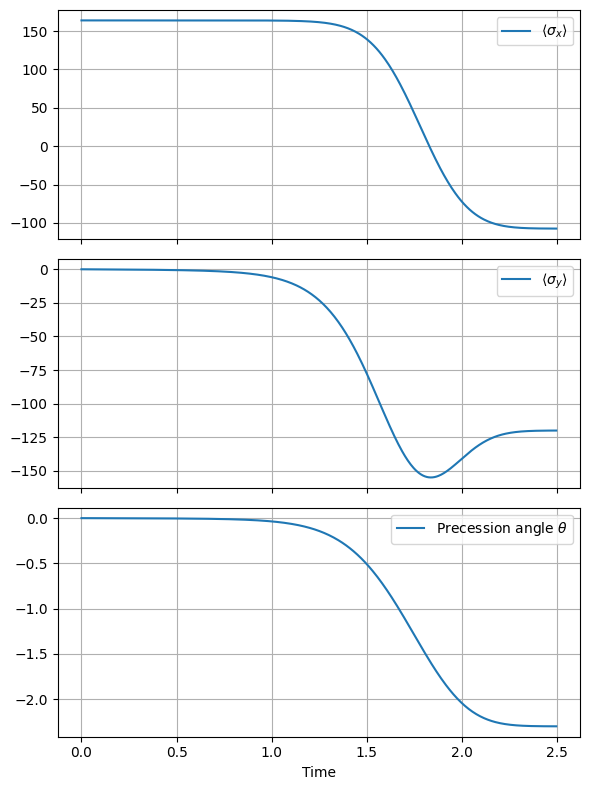

In [154]:
plot_precession(t_arr, sx, sy, theta)